# Predicting the mass of exoplanets from their properties

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/exoplanet-notebook/notebooks/regression/exoplanets.ipynb)


In this notebook, we will quantify the uncertainty of the mass of exoplanets associated with the predictions of several machine learning models using several exoplanets. To this aim, we will use the exoplanet dataset downloaded from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) and estimate the prediction intervals using the methods implemented in MAPIE.

In [ ]:
install_mapie = False
if install_mapie:
    !pip install mapie

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from mapie.regression import MapieRegressor
warnings.filterwarnings("ignore")

## 1. Data Loading

Let's start by loading the exoplanet dataset and show the main information.

In [2]:
exo_df = pd.read_csv("exoplanets_mass.csv", index_col=0)

In [3]:
exo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2746 entries, 1 to 2746
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Discovery_Method                          2746 non-null   object 
 1   Discovery_Year                            2746 non-null   int64  
 2   Solution_type                             2746 non-null   object 
 3   Planet_Orbital_Period_[day]               2284 non-null   float64
 4   Planet_Orbital_SemiMajorAxis_[day]        2017 non-null   float64
 5   Planet_Radius_[Earth_radius]              2168 non-null   float64
 6   Planet_Mass_[Earth_mass]                  2746 non-null   float64
 7   Planet_Mass_Provenance                    2746 non-null   object 
 8   Planet_Eccentricity                       1601 non-null   float64
 9   Planet_Eq_Temperature_[K]                 1056 non-null   float64
 10  Stellar_Effective_Temperature_[K]   

The dataset contains 21 variables giving complementary information on properties of the discovered planet, the star around which the planet revolves, and the system together with the type of discovery method. 7 variables are categorical, and 14 are continuous. Let's flag them for subsequent pre-processing.

Some properties show high dispersions between exoplanets and stars due to the astronomical nature of such systems. We therefore decide to use a log transformation for the following variables to approach normal distributions.

In [4]:
exo_df["Stellar_Mass_[Solar_mass]"].loc[exo_df["Stellar_Mass_[Solar_mass]"] == 0] = np.nan
vars2log = [
    "Planet_Orbital_Period_[day]",
    "Planet_Orbital_SemiMajorAxis_[day]",
    "Planet_Radius_[Earth_radius]",
    "Planet_Mass_[Earth_mass]",
    "Stellar_Radius_[Solar_radius]",
    "Stellar_Mass_[Solar_mass]",
    "Stellar_Effective_Temperature_[K]"
]
for var in vars2log:
    exo_df[var+"_log"] = np.log(exo_df[var])

In [5]:
vars2keep = list(set(exo_df.columns) - set(vars2log))
exo_df = exo_df[vars2keep]

In [6]:
exo_df.head()

,Planet_Orbital_SemiMajorAxis_[day]_log,Planet_Orbital_Period_[day]_log,System_Distance_[pc],Number_Planets,Planet_Radius_[Earth_radius]_log,System_V_Magnitude,Stellar_Metallicity_[dex],Discovery_Method,Stellar_Mass_[Solar_mass]_log,Stellar_Effective_Temperature_[K]_log,...,System_Ks_Magnitude,Solution_type,Planet_Eccentricity,System_Gaia_Magnitude,Number_Stars,Stellar_Metallicity_Radio,Stellar_Surface_Gravity_[log10(cm/s**2)],Discovery_Year,Planet_Eq_Temperature_[K],Planet_Mass_[Earth_mass]_log
1,5.799093,NaN,139.135,1,NaN,12.618,NaN,Imaging,-0.162519,8.308938,...,8.916,Published Confirmed,NaN,12.0572,1,NaN,NaN,2008,1700.0,8.294050
2,5.799093,NaN,139.135,1,NaN,12.618,NaN,Imaging,-0.162519,8.308938,...,8.916,Published Confirmed,NaN,12.0572,1,NaN,NaN,2008,1700.0,8.006368
3,5.799093,NaN,139.135,1,NaN,12.618,NaN,Imaging,-0.478036,8.292298,...,8.916,Published Confirmed,NaN,12.0572,1,NaN,4.0,2008,1800.0,8.006368
4,5.799093,NaN,139.135,1,2.925685,12.618,NaN,Imaging,-0.162519,8.308938,...,8.916,Published Confirmed,NaN,12.0572,1,NaN,NaN,2008,1800.0,7.841100
5,4.770685,NaN,128.484,1,NaN,16.186,0.01,Imaging,-1.771957,8.039157,...,10.386,Published Confirmed,NaN,14.3374,1,[Fe/H],4.5,2021,1450.0,7.147806


Throughout this notebook, the target variable will be "Planet_Mass_[Earth_mass]".

In [7]:
target = "Planet_Mass_[Earth_mass]_log"

In [8]:
num_cols = list(exo_df.columns[exo_df.dtypes == "float64"])
cat_cols = list(exo_df.columns[exo_df.dtypes != "float64"])
exo_df[cat_cols] = exo_df[cat_cols].astype(str)

In [9]:
planet_cols = [col for col in num_cols if "Planet_" in col]
star_cols = [col for col in num_cols if "Stellar_" in col]
system_cols = [col for col in num_cols if "System_" in col]

## 2. Data visualization

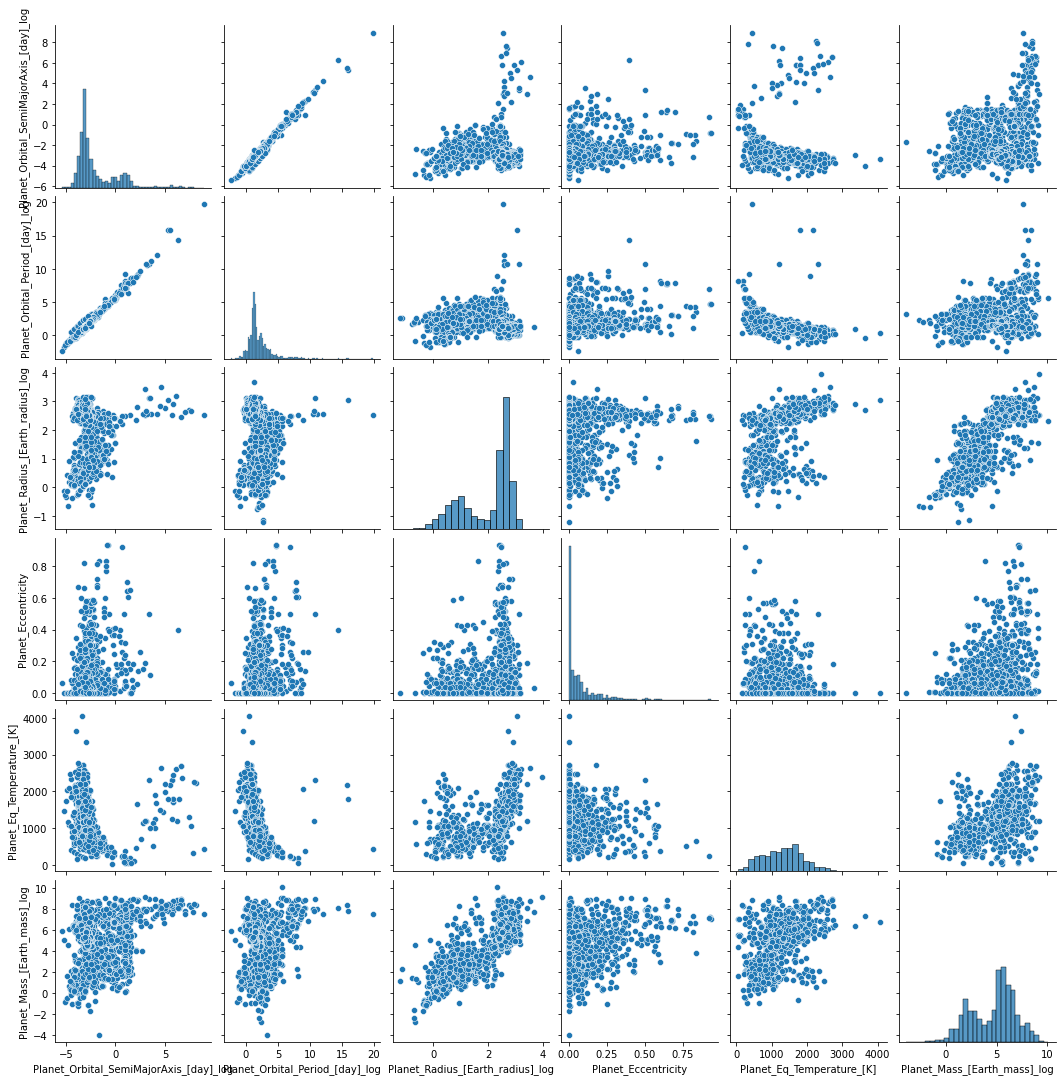

In [10]:
sns.pairplot(exo_df[planet_cols])

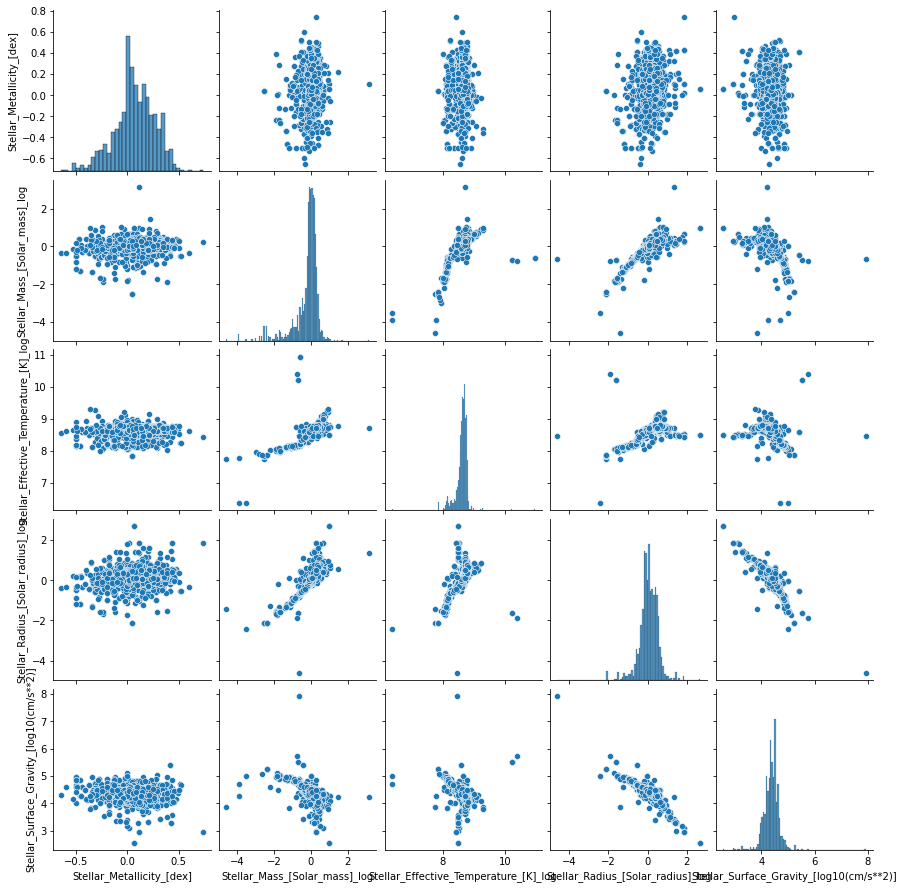

In [11]:
sns.pairplot(exo_df[star_cols])

## 3. Data preprocessing

In this section, we perform a simple preprocessing of the dataset in order to impute the missing values and encode the categorical variables.

In [12]:
endos = list(set(exo_df.columns) - set([target]))
X = exo_df[endos]
y = exo_df[target]

In [13]:
num_cols = list(X.columns[X.dtypes == "float64"])
cat_cols = list(X.columns[X.dtypes != "float64"])
X[cat_cols] = X[cat_cols].astype(str)

In [14]:
imputer_num = SimpleImputer(strategy="mean")
scaler_num = RobustScaler()
imputer_cat = SimpleImputer(strategy="constant", fill_value=-1)
encoder_cat = OneHotEncoder(
    categories="auto",
    drop=None,
    sparse=False,
    handle_unknown="ignore",
)

In [15]:
numerical_transformer = Pipeline(
    steps=[("imputer", imputer_num), ("scaler", scaler_num)]
)
categorical_transformer = Pipeline(
    steps=[("ordinal", OrdinalEncoder()), ("imputer", imputer_cat), ("encoder", encoder_cat)]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0,
)

In [16]:
X_2 = preprocessor.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_2, y, test_size=0.2, random_state=42, shuffle=True
)

## 4. First estimation of the uncertainties with MAPIE

### Uncertainty estimation

Here, we build our first prediction intervals with MAPIE. To this

In [62]:
def get_regressor(name):
    if name == "linear":
        mdl = LinearRegression()
    elif name == "polynomial":
        degree_polyn = 2
        mdl = Pipeline(
            [
                ("poly", PolynomialFeatures(degree=degree_polyn)),
                ("linear", LinearRegression())
            ]
        )
    elif name == "random_forest":
        mdl = RandomForestRegressor()
    return mdl

In [63]:
mdl = get_regressor("random_forest")

In [64]:
mapie = MapieRegressor(mdl, method="plus", cv=KFold(n_splits=5, shuffle=True))

In [65]:
mapie.fit(X_train, y_train)

MapieRegressor(cv=KFold(n_splits=5, random_state=None, shuffle=True),
               estimator=RandomForestRegressor())

In [66]:
alpha = np.arange(0.05, 1, 0.05)
y_train_pred, y_train_ps = mapie.predict(X_train, alpha=alpha)
y_test_pred, y_test_ps = mapie.predict(X_test, alpha=alpha)

### Visualization

The following function allows you to visualize the error bars estimated by MAPIE for the selected method and the given confidence level.

In [67]:
def plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pred_low,
    y_train_pred_high,
    y_test,
    y_test_pred,
    y_test_pred_low,
    y_test_pred_high,
    suptitle: str,
) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    ax1.errorbar(
        x=y_train,
        y=y_train_pred,
        yerr=(y_train_pred - y_train_pred_low, y_train_pred_high - y_train_pred),
        alpha=0.8,
        label="train",
        fmt=".",
    )
    ax1.errorbar(
        x=y_test,
        y=y_test_pred,
        yerr=(y_test_pred - y_test_pred_low, y_test_pred_high - y_test_pred),
        alpha=0.8,
        label="test",
        fmt=".",
    )
    ax1.plot(
        [y_train.min(), y_train.max()],
        [y_train.min(), y_train.max()],
        color="gray",
        alpha=0.5,
    )
    ax1.set_xlabel("True values", fontsize=12)
    ax1.set_ylabel("Predicted values", fontsize=12)
    ax1.legend()
    ax2.scatter(
        x=y_train, y=y_train_pred_high - y_train_pred_low, alpha=0.8, label="train", marker="."
    )
    ax2.scatter(x=y_test, y=y_test_pred_high - y_test_pred_low, alpha=0.8, label="test", marker=".")
    ax2.set_xlabel("True values", fontsize=12)
    ax2.set_ylabel("Interval width", fontsize=12)
    ax2.set_xscale("linear")
    ax2.set_ylim([0, np.max(y_test_pred_high - y_test_pred_low)*1.1])
    ax2.legend()
    std_all = np.concatenate([
        y_train_pred_high - y_train_pred_low, y_test_pred_high - y_test_pred_low
    ])
    type_all = np.array(
        ["train" for _ in range(y_train.shape[0])]
        + ["test" for _ in range(y_test.shape[0])]
    )
    x_all = np.arange(std_all.shape[0])
    order_all = np.argsort(std_all)
    std_order = std_all[order_all]
    type_order = type_all[order_all]
    ax3.scatter(
        x=x_all[type_order == "train"],
        y=std_order[type_order == "train"],
        alpha=0.8,
        label="train",
        marker=".",
    )
    ax3.scatter(
        x=x_all[type_order == "test"],
        y=std_order[type_order == "test"],
        alpha=0.8,
        label="test",
        marker=".",
    )
    ax3.set_xlabel("Order", fontsize=12)
    ax3.set_ylabel("Interval width", fontsize=12)
    ax3.legend()
    ax1.set_title("True vs Predicted values")
    ax2.set_title("Prediction Interval width vs True values")
    ax3.set_title("Ordered Prediction Interval width")
    plt.suptitle(suptitle, size=20)
    plt.show()


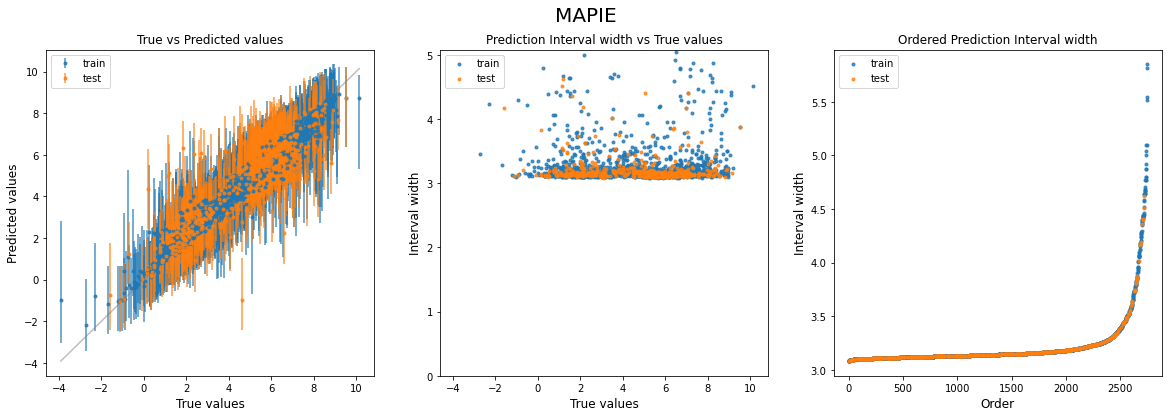

In [68]:
alpha_plot = int(np.where(alpha == 0.1)[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_ps[:, 0, alpha_plot],
    y_train_ps[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_ps[:, 0, alpha_plot],
    y_test_ps[:, 1, alpha_plot],
    "MAPIE",
)

## 5. Comparison of the uncertainty quantification methods

In the last section, we compare several uncertainty-quantification methods provided by MAPIE through the construction of "calibration plots" which compare the effective marginal coverage obtained on the test set with the target $1-\alpha$ coverage.

In [71]:
from typing_extensions import TypedDict
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from mapie.metrics import regression_coverage_score
Params = TypedDict("Params", {"method": str, "cv": Union[int, Subsample]})
STRATEGIES = {
    "naive": Params(method="naive"),
    # "jackknife": Params(method="base", cv=-1),
    # "jackknife_plus": Params(method="plus", cv=-1),
    # "jackknife_minmax": Params(method="minmax", cv=-1),
    "cv": Params(method="base", cv=5),
    "cv_plus": Params(method="plus", cv=5),
    "cv_minmax": Params(method="minmax", cv=5),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=20)),
    "jackknife_minmax_ab": Params(method="minmax", cv=Subsample(n_resamplings=20)),
}
mdl = get_regressor("random_forest")

In [72]:
y_pred, y_pis, scores = {}, {}, {}
for strategy, params in STRATEGIES.items():
    mapie = MapieRegressor(mdl, **params)
    mapie.fit(X_train, y_train)
    y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=alpha)
    scores[strategy] = [
        regression_coverage_score(y_test, y_pis[strategy][:, 0, i], y_pis[strategy][:, 1, i])
        for i, _ in enumerate(alpha)
    ]

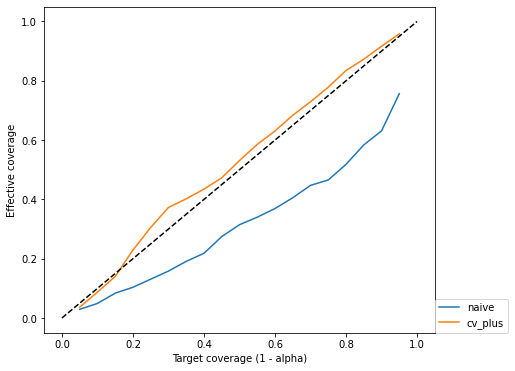

In [73]:
plt.figure(figsize=(7, 6))
plt.xlabel("Target coverage (1 - alpha)")
plt.ylabel("Effective coverage")
for strategy, params in STRATEGIES.items():
    plt.plot(1 - alpha, scores[strategy], label=strategy)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.legend(loc=[1, 0])